In [1]:
from opac_multi import *

opac("/scratch/gpfs/hl1835/optab_opacity_data/m10_multi_newbin2/slurm_script", "ross", savedata=True, syms=100)

Reading 5785 layers ... 


/scratch/gpfs/hl1835/optab/sample/python/opac_multi.py:40: RuntimeWarning: divide by zero encountered in log10
  'logkappa_p': [np.log10((data['plac'] + data['plal']) / data['rho'][0]) for data in datasets],
/scratch/gpfs/hl1835/optab/sample/python/opac_multi.py:43: RuntimeWarning: divide by zero encountered in log10
  'logkappa_a': [np.log10(data['absmean'] / data['rho'][0]) for data in datasets]})


Data saved to /scratch/gpfs/hl1835/optab_opacity_data/m10_multi_newbin2/slurm_script/output.h5


In [2]:
# after saving the h5 data, interpolate it
import numpy as np
from matplotlib import pyplot as plt
import h5py
from scipy.interpolate import interp1d
from astropy import units as u
from astropy import constants as cn

workdir = "/scratch/gpfs/hl1835/optab_opacity_data/m10_multi_newbin2/slurm_script/"
file = workdir + "output.h5"
with h5py.File(file, "r") as f:
    temp = f["temp"][:]
    rho = f["rho"][:]
    logkappa_r = f["logkappa_r"][:] # dimension: (temp, rho)
    logkappa_p = f["logkappa_p"][:] # dimension: (temp, rho)
    logkappa_s = f["logkappa_s"][:] # dimension: (temp, rho)
    logkappa_e = f["logkappa_e"][:] # dimension: (temp, rho)
    logkappa_a = f["logkappa_a"][:] # dimension: (temp, rho)

ntemp, npre, nfreq = 81, 65, 148  # from the temperature grid design, see work/FastChem-lnk_interpolate_dev/input/prep_FastChem.dat
t_arr = temp[::npre]    
rho_arr = np.logspace(-20.5,-7.5,131)
logkappa_r_interp = np.zeros((len(t_arr), len(rho_arr), nfreq))
logkappa_p_interp = np.zeros((len(t_arr), len(rho_arr), nfreq))
logkappa_s_interp = np.zeros((len(t_arr), len(rho_arr), nfreq))
logkappa_e_interp = np.zeros((len(t_arr), len(rho_arr), nfreq))
logkappa_a_interp = np.zeros((len(t_arr), len(rho_arr), nfreq))
for i, t in enumerate(t_arr):
    for j in range(nfreq):
        logkappa_r_interp[i,:,j] = np.interp(np.log10(rho_arr), np.log10(rho[i*npre:(i+1)*npre]), logkappa_r[i*npre:(i+1)*npre,j])
        logkappa_p_interp[i,:,j] = np.interp(np.log10(rho_arr), np.log10(rho[i*npre:(i+1)*npre]), logkappa_p[i*npre:(i+1)*npre,j])
        logkappa_s_interp[i,:,j] = np.interp(np.log10(rho_arr), np.log10(rho[i*npre:(i+1)*npre]), logkappa_s[i*npre:(i+1)*npre,j])
        logkappa_e_interp[i,:,j] = np.interp(np.log10(rho_arr), np.log10(rho[i*npre:(i+1)*npre]), logkappa_e[i*npre:(i+1)*npre,j])
        logkappa_a_interp[i,:,j] = np.interp(np.log10(rho_arr), np.log10(rho[i*npre:(i+1)*npre]), logkappa_a[i*npre:(i+1)*npre,j])


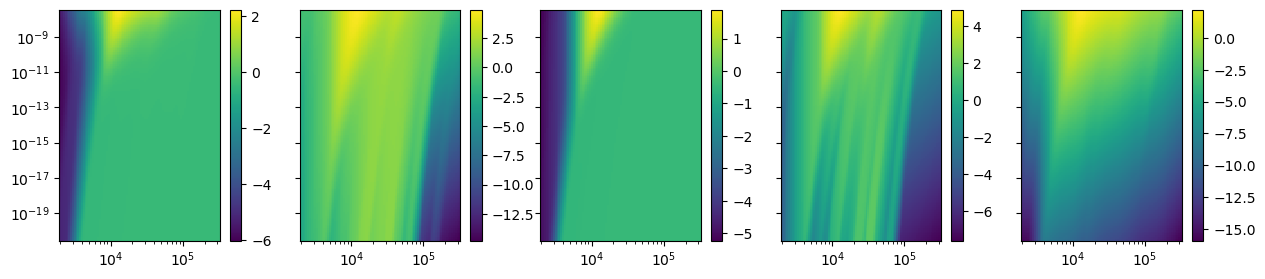

In [3]:
# %matplotlib widget
fig, ax = plt.subplots(1,5, figsize=(15,3), sharex=True, sharey=True)
freq_idx = 147
pmesh0 = ax[0].pcolormesh(t_arr, rho_arr, logkappa_r_interp[:,:,freq_idx].T)
pmesh1 = ax[1].pcolormesh(t_arr, rho_arr, logkappa_p_interp[:,:,freq_idx].T)
pmesh2 = ax[2].pcolormesh(t_arr, rho_arr, logkappa_s_interp[:,:,freq_idx].T)
pmesh3 = ax[3].pcolormesh(t_arr, rho_arr, logkappa_e_interp[:,:,freq_idx].T)
pmesh4 = ax[4].pcolormesh(t_arr, rho_arr, logkappa_a_interp[:,:,freq_idx].T)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
cbar0 = fig.colorbar(pmesh0, ax=ax[0])
cbar1 = fig.colorbar(pmesh1, ax=ax[1])
cbar2 = fig.colorbar(pmesh2, ax=ax[2])
cbar3 = fig.colorbar(pmesh3, ax=ax[3])
cbar4 = fig.colorbar(pmesh4, ax=ax[4])

In [6]:
# fix NaN at lowest T and highest freq: extrapolate using the same density at higher T
print(np.isnan(logkappa_a_interp).sum())
if np.isnan(logkappa_r_interp[0,-1,-2]):
    logkappa_r_interp[0,:,-2] = 2*logkappa_r_interp[1,:,-2] - logkappa_r_interp[2,:,-2]
    logkappa_p_interp[0,:,-2] = 2*logkappa_p_interp[1,:,-2] - logkappa_p_interp[2,:,-2]
    logkappa_s_interp[0,:,-2] = 2*logkappa_s_interp[1,:,-2] - logkappa_s_interp[2,:,-2]
    logkappa_e_interp[0,:,-2] = 2*logkappa_e_interp[1,:,-2] - logkappa_e_interp[2,:,-2]
    logkappa_a_interp[0,:,-2] = 2*logkappa_a_interp[1,:,-2] - logkappa_a_interp[2,:,-2]

0


In [7]:
# save the interpolated data
wavelen_arr = np.concatenate([[10],np.linspace(100,3600,36),[3620,3640],np.linspace(3645,3795,31),np.linspace(3800,3950,16),np.linspace(4000,7000,31),np.linspace(7200,13000,30),[100000]]) * u.AA
# design unit system
rg = (cn.G*1e7*cn.M_sun/cn.c**2).to(u.cm).value
dens_unit_ = 1e-16
temp_unit_ = 1e4
mu = 0.62
lunit_ = rg
munit_ = dens_unit_*lunit_**3
kappa_unit_ = lunit_**2/munit_
v_unit_ = np.sqrt(cn.k_B*temp_unit_*u.K/mu/cn.m_p).to(u.cm/u.s).value
time_unit_ = lunit_/v_unit_
freq_unit_ = (cn.k_B*temp_unit_*u.K/cn.h/u.Hz).to(1).value # kT_unit/h
print(lunit_,munit_,time_unit_,kappa_unit_)

freq_multi_arr = (cn.c/wavelen_arr).to(u.Hz)
freq_multi_unit_arr_ = np.concatenate([[0,],freq_multi_arr[-2:0:-1].value]) / freq_unit_   # start with 0, end with nu_max (not infty)

1476625038050.1248 3.219664984827565e+20 1279744.6541201456 6772.199944005381


In [8]:
# save the interpolated data
# design unit system
rg = (cn.G*1e7*cn.M_sun/cn.c**2).to(u.cm).value
dens_unit_ = 1e-16
temp_unit_ = 1e4
mu = 0.62
lunit_ = rg
munit_ = dens_unit_*lunit_**3
kappa_unit_ = lunit_**2/munit_
v_unit_ = np.sqrt(cn.k_B*temp_unit_*u.K/mu/cn.m_p).to(u.cm/u.s).value
time_unit_ = lunit_/v_unit_
print(lunit_,munit_,time_unit_,kappa_unit_)
with h5py.File(workdir+"opacity_multinew_optab_m10_unit_log.h5", "w") as f:
    f.attrs['lunit'] = lunit_
    f.attrs['densunit'] = dens_unit_
    f.attrs['Tunit'] = temp_unit_
    f.attrs['kappaunit'] = kappa_unit_
    f.attrs['message'] = 'Opacities, temperatures, densities, frequency in custom units, wavelength in AA, [M/H]=-4.0.'
    f.create_dataset("freq", data=freq_multi_unit_arr_)
    f.create_dataset("wavelen", data=wavelen_arr[-2::-1].value)
    f.create_dataset('logtgas',data=np.log10(t_arr)-np.log10(temp_unit_))
    f.create_dataset('logdens',data=np.log10(rho_arr)-np.log10(dens_unit_))
    gray = f.create_group('gray')
    gray.create_dataset('logkappa_r',data=np.transpose(logkappa_r_interp[:,:,-1],(1,0))-np.log10(kappa_unit_))
    gray.create_dataset('logkappa_p',data=np.transpose(logkappa_p_interp[:,:,-1],(1,0))-np.log10(kappa_unit_))
    gray.create_dataset('logkappa_s',data=np.transpose(logkappa_s_interp[:,:,-1],(1,0))-np.log10(kappa_unit_))
    gray.create_dataset('logkappa_e',data=np.transpose(logkappa_e_interp[:,:,-1],(1,0))-np.log10(kappa_unit_))
    gray.create_dataset('logkappa_a',data=np.transpose(logkappa_a_interp[:,:,-1],(1,0))-np.log10(kappa_unit_))
    grp = f.create_group('multi')
    grp.create_dataset('logkappa_r',data=np.transpose(logkappa_r_interp[:,:,:-1],(2,1,0))-np.log10(kappa_unit_))
    grp.create_dataset('logkappa_p',data=np.transpose(logkappa_p_interp[:,:,:-1],(2,1,0))-np.log10(kappa_unit_))
    grp.create_dataset('logkappa_s',data=np.transpose(logkappa_s_interp[:,:,:-1],(2,1,0))-np.log10(kappa_unit_))
    grp.create_dataset('logkappa_e',data=np.transpose(logkappa_e_interp[:,:,:-1],(2,1,0))-np.log10(kappa_unit_))
    grp.create_dataset('logkappa_a',data=np.transpose(logkappa_a_interp[:,:,:-1],(2,1,0))-np.log10(kappa_unit_))

1476625038050.1248 3.219664984827565e+20 1279744.6541201456 6772.199944005381


In [9]:
# save data for gray calculation
with h5py.File(workdir+"opacity_gray_optab_m10_unit_log.h5", "w") as f:
    f.attrs['lunit'] = lunit_
    f.attrs['densunit'] = dens_unit_
    f.attrs['Tunit'] = temp_unit_
    f.attrs['kappaunit'] = kappa_unit_
    f.attrs['message'] = 'Opacities, temperatures, densities, frequency in custom units, [M/H]=-4.0.'    # gray opacity
    f.create_dataset('logtgas',data=np.log10(t_arr)-np.log10(temp_unit_))
    f.create_dataset('logdens',data=np.log10(rho_arr)-np.log10(dens_unit_))
    main = f.create_group('main')
    main.create_dataset('logkappa_p',data=logkappa_p_interp[:,:,-1].T-np.log10(kappa_unit_))
    main.create_dataset('logkappa_s',data=logkappa_s_interp[:,:,-1].T-np.log10(kappa_unit_))
    main.create_dataset('logkappa_r',data=logkappa_r_interp[:,:,-1].T-np.log10(kappa_unit_))

In [14]:
# save data for analytical calculation
freq_idx = 44    # 5600-5700 AA
with h5py.File(workdir+"opacity_gray_optab_m10.h5", "w") as f:
    f.attrs['message'] = '[M/H]=-4.0, all quantities in cgs units.'
    # gray opacity
    main = f.create_group('main')
    main.create_dataset('Temp',data=t_arr)
    main.create_dataset('Den',data=rho_arr)
    main.create_dataset('kappa_r',data=10**logkappa_r_interp[:,:,-1])
    main.create_dataset('kappa_p',data=10**logkappa_p_interp[:,:,-1])
    main.create_dataset('kappa_s',data=10**logkappa_s_interp[:,:,-1])
    main.create_dataset('kappa_e',data=10**logkappa_e_interp[:,:,-1])
    main.create_dataset('kappa_a',data=10**logkappa_a_interp[:,:,-1])
    grp = f.create_group('select')
    grp.create_dataset('kappa_r',data=10**logkappa_r_interp[:,:,freq_idx])
    grp.create_dataset('kappa_p',data=10**logkappa_p_interp[:,:,freq_idx])
    grp.create_dataset('kappa_s',data=10**logkappa_s_interp[:,:,freq_idx])
    grp.create_dataset('kappa_e',data=10**logkappa_e_interp[:,:,freq_idx])
    grp.create_dataset('kappa_a',data=10**logkappa_a_interp[:,:,freq_idx])